In [1]:
import pandas as pd
import numpy as np
from numpy.linalg import inv
from tqdm import tqdm

import matplotlib.pyplot as plt

In [2]:
dat = pd.read_csv('data/01_standard_practice.csv')

x = dat['x']
y = dat['y']
sig_y = dat['sig_y']

In [3]:
import decimal

def linear(x, params):
    return params[0] * x + params[1]

def gaussian(y, sigma, mu):
    return ((1 / np.sqrt(2 * np.pi * sigma**2)) * np.exp( -(y - mu)**2 / (2 * sigma**2) ))

def likelihood(func, x, y, sig_y, params):
    '''
    Inputs:    
        y   - the dependent variable array of observed measurements
        m   - slope
        b   - intercept
        P_b - Probability of a bad point
        Y_b - mean of distribution of bad points
        V_b - variance of distribution of bad points
        sig_y - variance in y space
        
    Outputs:
        likelihood = p({y_i} | m, b, P_b, Y_b, V_b, I)
    '''
    
    m = params[0]
    b = params[1]
    P_b = params[2]
    Y_b = params[3]
    V_b = params[4]
    
    likelihood = 1
    
    for i in range(len(x)):        
        foreground = gaussian(y[i], sig_y[i], func(x[i], [m, b]))
        background = gaussian(y[i], np.sqrt(V_b + sig_y[i]**2), Y_b)
        #print(((1 - P_b) * foreground) + ((P_b) * background))
        
        likelihood *= ((1 - P_b) * foreground) + ((P_b) * background)
        
    return likelihood

In [4]:
import random
import pandas as pd

def metropolis_hastings(kernel, func, x, y, sig_y, params, steps = 5000, stepsize = 0.005):
    param_set = []
        
    param_array = []
    param_ub = []
    param_lb = []
        
    '''
    
    Initialize chain
    
    '''
        
    for key in params.keys():
        param_array.append(params[key][0])
        param_ub.append(params[key][1])
        param_lb.append(params[key][2])
        
    likelihood = kernel(func, x, y, sig_y, param_array)
    tarr = param_array.copy()
    tarr.append(likelihood)    
    param_set.append(tarr)
    
    print(param_array)
    
    '''
    
    Start stepping
    
    '''
    
    for i in tqdm(range(steps)):
        #print(param_set)
        #print(param_array)
        prev_param_array = param_array
        prev_likelihood = param_set[-1][-1]
        
        for j in range(len(param_array)):
            newparam = random.gauss(prev_param_array[j], stepsize)
            if j in [2]:
                #print('bleh')
                #newparam = random.uniform(param_lb[j], param_ub[j])                
                while (newparam < 0) or (newparam > 1):
                    newparam = random.gauss(prev_param_array[j], stepsize)
                #print('blah')
            
            param_array[j] = newparam
            
        likelihood = kernel(func, x, y, sig_y, param_array)
        R = random.uniform(0, 1)
        
        if R < (likelihood / prev_likelihood):
            tarr = param_array.copy()
            tarr.append(likelihood)
            param_set.append(tarr)
        else:            
            tarr = prev_param_array.copy()
            tarr.append(prev_likelihood)
            param_set.append(tarr)
            
    columns = []
    for key in params.keys():
        columns.append(key)
    columns.append('likelihood')
            
    df = pd.DataFrame(np.array(param_set), columns = columns)

    
    return df
        
params = {'m' : np.array([2, 0, 5]),
            'b' : np.array([30, 20, 40]),
            'P_b' : np.array([0.1, 0, 1]),
            'Y_b' : np.array([0, -100, 100]),
            'V_b' : np.array([10, -100, 100])}

df = metropolis_hastings(likelihood, linear, x, y, sig_y, params)


[2, 30, 0.1, 0, 10]


100%|█████████████████████████████████████████████████████████████████████| 5000/5000 [00:03<00:00, 1397.47it/s]


In [5]:
print(df)

#df[['V_b']]

             m          b       P_b       Y_b        V_b     likelihood
0     2.000000  30.000000  0.100000  0.000000  10.000000  1.368917e-135
1     2.000334  29.996055  0.104621  0.001333   9.990748  1.236353e-135
2     2.003264  29.999021  0.093192  0.004287   9.997687  1.655128e-135
3     1.996144  29.997158  0.093280  0.008518   9.993973  1.478112e-135
4     1.987539  30.004550  0.094688 -0.008080   9.996690  1.135843e-135
...        ...        ...       ...       ...        ...            ...
4996  2.439361  30.017059  0.095162  0.432587   9.947427  2.867060e-140
4997  2.433541  30.025898  0.101997  0.434828   9.943050  2.867060e-140
4998  2.429196  30.024078  0.113570  0.444085   9.940388  2.867060e-140
4999  2.427625  30.023727  0.122479  0.446729   9.938149  2.867060e-140
5000  2.427627  30.019348  0.125754  0.445488   9.937324  2.867060e-140

[5001 rows x 6 columns]


In [6]:
from scipy.integrate import trapezoid
import numpy as np

df['marginalized'] = trapezoid(df['likelihood'], x = df['V_b'])
#print(df)

print(df)

             m          b       P_b       Y_b        V_b     likelihood  \
0     2.000000  30.000000  0.100000  0.000000  10.000000  1.368917e-135   
1     2.000334  29.996055  0.104621  0.001333   9.990748  1.236353e-135   
2     2.003264  29.999021  0.093192  0.004287   9.997687  1.655128e-135   
3     1.996144  29.997158  0.093280  0.008518   9.993973  1.478112e-135   
4     1.987539  30.004550  0.094688 -0.008080   9.996690  1.135843e-135   
...        ...        ...       ...       ...        ...            ...   
4996  2.439361  30.017059  0.095162  0.432587   9.947427  2.867060e-140   
4997  2.433541  30.025898  0.101997  0.434828   9.943050  2.867060e-140   
4998  2.429196  30.024078  0.113570  0.444085   9.940388  2.867060e-140   
4999  2.427625  30.023727  0.122479  0.446729   9.938149  2.867060e-140   
5000  2.427627  30.019348  0.125754  0.445488   9.937324  2.867060e-140   

       marginalized  
0     2.075947e-137  
1     2.075947e-137  
2     2.075947e-137  
3     2.075

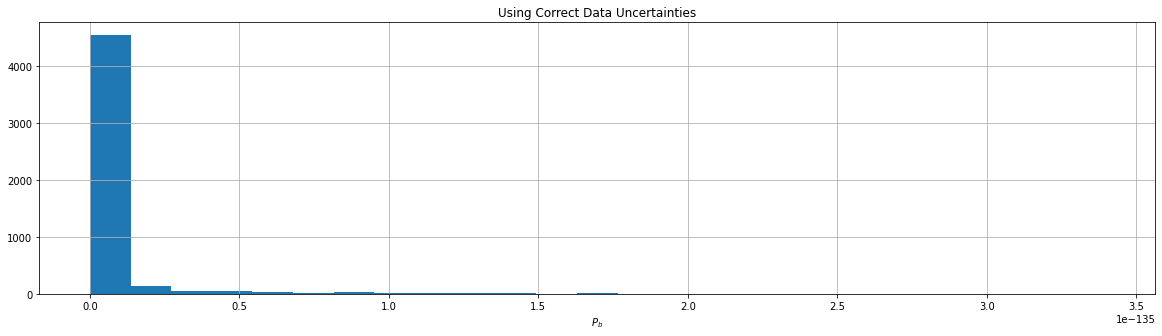

In [7]:
plt.figure(figsize=(20,5))
#plt.subplot(1, 2, 1)
plt.hist(df['likelihood'], bins = 25)
plt.title("Using Correct Data Uncertainties")
plt.xlabel(r'$P_b$')
plt.grid()

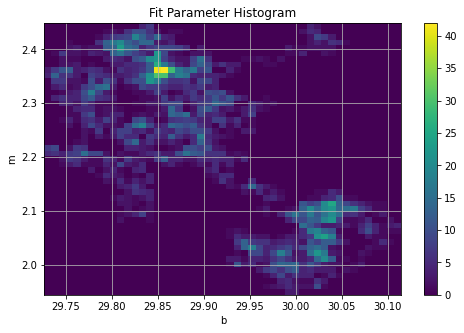

In [8]:
#param_set = df.to_dict()
likelihoods = df['likelihood']
m = df['m']
b = df['b']

y_min = np.min(m)
y_max = np.max(m)

x_min = np.min(b)
x_max = np.max(b)

x_bins = np.linspace(x_min, x_max, 50)
y_bins = np.linspace(y_min, y_max, 50)

plt.figure(figsize=(8,5))

#plt.xlim(-100, 100)
#plt.ylim(1.5, 3)
plt.hist2d(b, m, bins =[x_bins, y_bins])
plt.title("Fit Parameter Histogram")

plt.xlabel('b')
plt.ylabel('m')
plt.grid()
plt.colorbar()


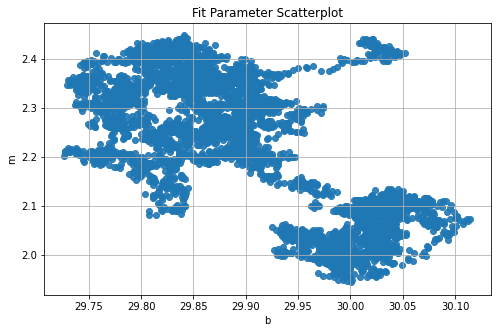

In [9]:
plt.figure(figsize=(8,5))

plt.scatter(b, m, alpha = 0.9)

plt.title("Fit Parameter Scatterplot")
plt.xlabel('b')
plt.ylabel('m')
#plt.xlim(29.25,30.5)
#plt.ylim(1.5,3.2)
plt.grid()

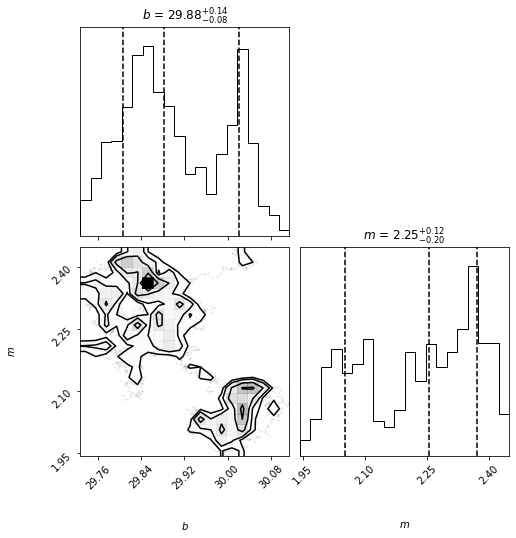

In [10]:
import corner
import numpy as np

samples = np.array([b, m]).T
figure = corner.corner(samples, labels=[r"$b$", r"$m$"], quantiles=[0.16, 0.5, 0.84],
                       show_titles=True, title_kwargs={"fontsize": 12})
figure.set_size_inches(8,8)

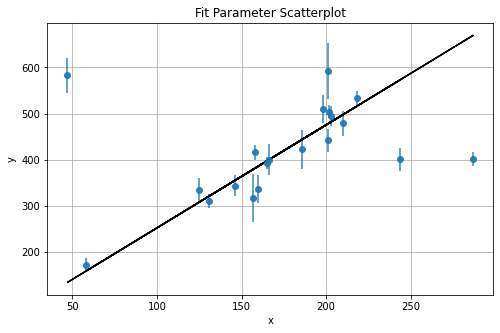

In [11]:
mval = np.mean(m)
bval = np.mean(b)

plt.figure(figsize=(8,5))

plt.errorbar(x, y, yerr = sig_y, alpha = 0.9, fmt = 'o')

plt.plot(x, linear(x, [mval, bval]), color = 'black')

plt.title("Fit Parameter Scatterplot")
plt.xlabel('x')
plt.ylabel('y')
plt.grid()


In [12]:
param_set = metropolis_hastings(likelihood, linear, x, y, sig_y, params, steps = 15000)
P_b = param_set['P_b']
m, b = param_set['m'], param_set['b']

param_set = metropolis_hastings(likelihood, linear, x, y, sig_y / 2, params, steps = 15000)
P_b2  = param_set['P_b']

[2, 30, 0.1, 0, 10]


100%|███████████████████████████████████████████████████████████████████| 15000/15000 [00:09<00:00, 1544.00it/s]


[2, 30, 0.1, 0, 10]


  0%|                                                                                 | 0/15000 [00:00<?, ?it/s]/tmp/ipykernel_21136/862712516.py:55: RuntimeWarning: invalid value encountered in double_scalars
  if R < (likelihood / prev_likelihood):
100%|███████████████████████████████████████████████████████████████████| 15000/15000 [00:08<00:00, 1677.20it/s]


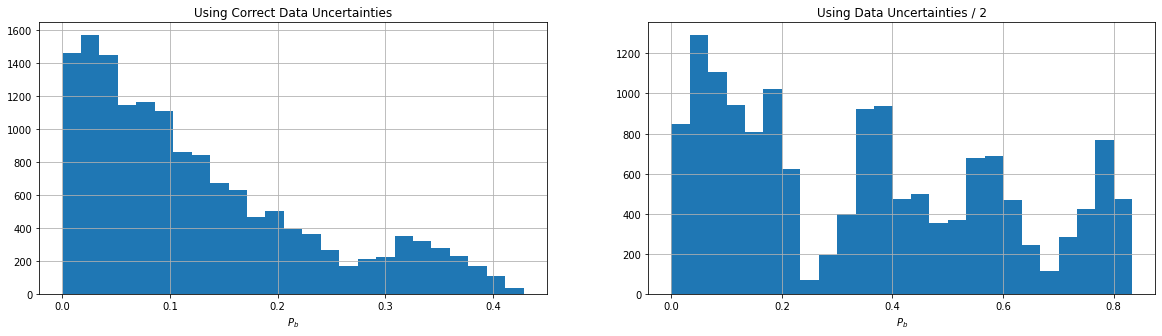

In [13]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.hist(P_b, bins = 25)
plt.title("Using Correct Data Uncertainties")
plt.xlabel(r'$P_b$')
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(P_b2, bins = 25)
plt.title("Using Data Uncertainties / 2")
plt.xlabel(r'$P_b$')
plt.grid()

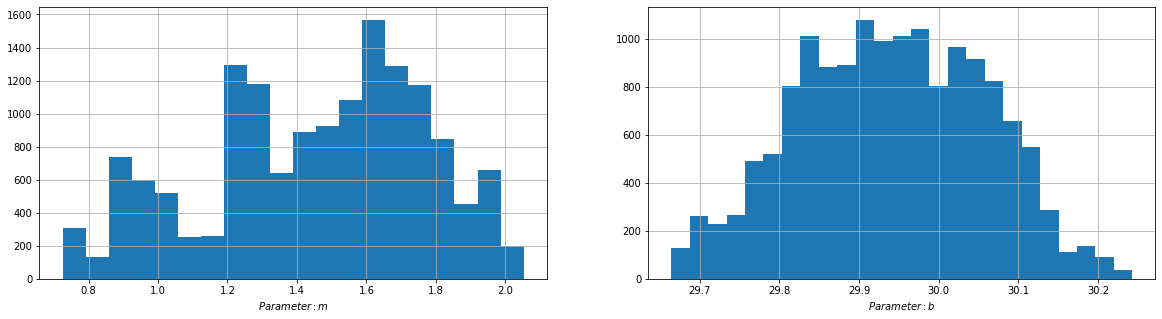

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.hist(m, bins = 20)
#plt.title("m")
plt.xlabel(r'$Parameter: m$')
plt.grid()

plt.subplot(1, 2, 2)
plt.hist(b, bins = 25)
#plt.title("b")
plt.xlabel(r'$Parameter: b$')
plt.grid()